In [66]:
import sys
sys.path.append('../SRC')
import PIOT_imports
import Sinkhorn
import CoDaS_PIOT_general_prior_C
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import pickle
import itertools
import matplotlib
from scipy.stats import dirichlet

In [137]:
def MCMC_sim(T_1, alpha, lam, std, shift, num_burn_in = 10000, num_sampling = 1000000, num_lag = 200):

    mean = 0.0
    std = std
    
    nr, nc = len(T_1), len(T_1[0])
    
    alphas = alpha.reshape((-1,))

    print(T_1)
    K_1, data_K_1, data_K_burn_in, acceptRatio_1 = \
    CoDaS_PIOT_general_prior_C.runs(T_1, alphas, lam, mean, std, shift, num_burn_in, num_sampling, num_lag)

    print('Done...')
    return data_K_1, data_K_burn_in

def autocorr(x,lags,var):
    n_vectors = len(x)
    nr, nc = len(x[0]), len(x[0][0])
    mean = x.mean(axis = 0)
    xp = torch.stack([row-mean for row in x])
    corr = np.array([np.correlate(xp[:,r,c],xp[:,r,c],'full') \
                     for r, c in itertools.product(range(nr), range(nc))])[:, n_vectors-1:]
    div = np.array([n_vectors-i for i in range(len(lags))])
    acorr = corr.sum(axis=0)[:len(lags)]/var/div

    return acorr[:len(lags)]

def plot_row_sum_corr(data):
    nc = len(data[0][0])
    row_sum = []

    for i in range(len(data)):
        row_sum.append(np.array(data[i].sum(axis=1)))

    lags = range(1000)
    var = np.var(row_sum, axis = 0).sum()
    corr = CoDaS_plot.autocorr(row_sum, lags, var)

    x = range(len(lags))
    plus_1_div_exp = 1/np.exp(1)*np.ones(len(lags))
    minus_1_div_exp = - plus_1_div_exp

    plt.plot(lags, corr)
    plt.plot(x, plus_1_div_exp, 'k--')
    plt.plot(x, minus_1_div_exp, 'k--')
    
def plot_corr(data, lag = 1000):
    
    lags = range(lag)
    var = torch.sum(torch.var(data, axis = 0))
    corr = autocorr(data, lags, var)
    
    x = range(len(lags))
    plus_1_div_exp = 1/np.exp(1)*np.ones(len(lags))
    minus_1_div_exp = - plus_1_div_exp

    plt.plot(lags, corr)
    plt.plot(x, plus_1_div_exp, 'k--')
    plt.plot(x, minus_1_div_exp, 'k--')
    plt.xlabel('t')
    plt.ylabel("R(t)")
        
def plot_one_matrix_simplex(M):
    CoDaS_plot.plot_points(np.array([t[0] for t in M]), 'r', 5)
    CoDaS_plot.plot_points(np.array([t[1] for t in M]), 'g', 5)
    CoDaS_plot.plot_points(np.array([t[2] for t in M]), 'b', 5)
    
def plot_samples(data, bw_method = 0.1):
    nr = len(data[0])
    nc = len(data[0][0])
    x_i = [[] for _ in range(nr)]
    df_all = pd.DataFrame()

    colors = ['r', 'g', 'b']

    for i in range(nr):
        for j in range(nc):
            x_i[i] = np.array([K[i][j].numpy() for K in data])


            df = pd.DataFrame(x_i[i], columns = ['({},{})'.format(i, j)])

            ax1 = df.plot.density(bw_method=bw_method)
            ax1.set_xlim(0, 1)
            ax1.set_ylim(bottom=0)
            
    
def plot_samples_column(data, bw_method = 0.1):
    nr = len(data[0])
    nc = len(data[0][0])
    x_i = [[] for _ in range(nr)]
    df_all = pd.DataFrame()

    colors = ['r', 'g', 'b']

    for j in range(nc):
        x_i = np.array([[K[i][j].numpy() for i in range(nr)] for K in data])

        df = pd.DataFrame(x_i, columns = ['({},{})'.format(i,j) for i in range(nr) ])

        ax1 = df.plot.density(bw_method=bw_method)
        ax1.set_xlim(0, 1)
        
def running_average(data):
    
    nc = len(data[0][0])
    x = []

    for i in range(len(data)):
        x.append(np.array(data[i].sum(axis=1)))

    x = np.array(x)
    nr = len(x)
    nc = len(x[0])
    ra = [x[0]]
    for i in range(1, nr):
        ra.append(ra[i-1] + x[i])
    for i in range(1, nr):
        ra[i] /= (i+1)
    return ra

def plot_row_sum_running_average(data):
    ra = running_average(data)
    df_ra = pd.DataFrame(ra)
    ax = df_ra.plot()
    ax.set_ylabel('Row sum')
    ax.set_xlabel('# samples')
    #ax.set_ylim(bottom=0.2)


def normalizeFactor(T, s):
    m, n = len(T), len(T[0])
    return np.exp( (s + np.log(T).sum()) /m/n )

def addNoise(T, noise, r, c, s):
    T_p = T.clone()
    T_p[r][c] = T_p[r][c] + noise
    a = normalizeFactor(T_p, s)
    T_p = T_p / a
    return T_p.clone(), a

def plot_pdf_all(data, C, C_ma, C_ma2, bw_method = 0.05):
    

    
    data_all = []
    for key in data.keys():
        data_all += data[key]
    nr = len(data[key][0])
    nc = len(data[key][0][0])

    colors = ['r', 'g', 'b']
    
    tmp = [data_all[j].numpy() for j in range(len(data_all)) ]
    med = np.median(tmp, axis=0)

    for i in range(nr):
        for j in range(nc):
            if i == 0 and j == 8:
                x_i = np.array([K[i][j].numpy() for K in data_all])
                df = pd.DataFrame(x_i, columns = ['({},{})'.format(i+1,j+1)])
                ax1 = df.plot.density(bw_method=bw_method, color='k')
                ax1.legend(loc='upper left')
                ylim = ax1.get_ylim()
                ax1.vlines(C[i][j], ymin = 0, ymax = 1e8, linestyles = 'solid', color='b', lw=2)
                ax1.vlines(med[i][j], ymin = 0, ymax = 1e8, linestyles = 'dashed', color='r', lw=2)

                # Ma's result 
                ax1.vlines(C_ma[i][j], ymin = 0, ymax = 1e8, linestyles = 'dashdot', color='g', lw=2)
                ax1.vlines(C_ma2[i][j], ymin = 0, ymax = 1e8, linestyles = 'dotted', color='y', lw=2)
                ax1.set_ylim((0, ylim[1]))
                ax1.set_xlim(left=0.01, right = 0.04)

                # inset axes....
                axins = ax1.inset_axes([0.7, 0.3, 0.25, 0.4])
                axins.vlines(C[i][j], ymin = 0, ymax = 0.1, linestyles = 'solid', color='b', lw=4)
                axins.vlines(med[i][j], ymin = 0, ymax = 0.1, linestyles = 'dashed', color='r', lw=4)

                # Ma's result 
                axins.vlines(C_ma[i][j], ymin = 0, ymax = 0.1, linestyles = 'dashdot', color='g', lw=4) 
                axins.vlines(C_ma2[i][j], ymin = 0, ymax = 0.1, linestyles = 'dotted', color='y', lw=4)
                # sub region of the original image
                x1, x2, y1, y2 = C[i][j]-3e-4, C[i][j]+3e-4, 0, 0.1
                axins.set_xlim(x1, x2)
                axins.set_ylim(y1, y2)
                mid = np.round(C[i][j], 4)
                axins.set_xticklabels([])
                axins.set_yticklabels([])

                ax1.indicate_inset_zoom(axins, edgecolor="black")

    
def plot_pdf_CR(data, bw_method = 0.05):
    noises = [-0.01, -0.005, 0.0, 0.005, 0.01]
    n_noise = len(data)
    nr = len(data[str(noises[0])][0])
    nc = len(data[str(noises[0])][0][0])
    #x_i = [[] for _ in range(nr)]
    df_all = pd.DataFrame()

    color = ['b', 'b', 'g', 'g', 'y', 'y', 'orange', 'orange', 'r', 'r']
    linestyles = ('-', '--')
    styles = ['b-', 'b--', 'c-', 'c--', 'k-', 'k--', 'm-', 'm--', 'r-', 'r--']


    # x_00+x_11 v.s. x_01+x_10
    df = pd.DataFrame()
    for k in range(n_noise):
        x_1 = np.array([K[0][0].numpy()+K[1][1].numpy() for K in data[str(noises[k])]])
        df[(noises[k],"$C_{11}+C_{22}$")] = x_1
        x_2 = np.array([K[1][0].numpy()+K[0][1].numpy() for K in data[str(noises[k])]])
        df[(noises[k],"$C_{21}+C_{12}$")] = x_2

    #ax1 = df.plot.density(bw_method=bw_method, color = color, ls = linestyles)
    ax1 = df.plot.density(bw_method=bw_method, style=styles)
    ax1.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    ax1.set_xlim(0, 0.6)
    ax1.set_ylim(bottom=0)

    # x_01+x_02 v.s. x_11+x_12
    df = pd.DataFrame()
    for k in range(n_noise):
        x_1 = np.array([K[0][1].numpy()+K[1][2].numpy() for K in data[str(noises[k])]])
        df[(noises[k],"$C_{12}+C_{23}$")] = x_1
        x_2 = np.array([K[0][2].numpy()+K[1][1].numpy() for K in data[str(noises[k])]])
        df[(noises[k],"$C_{13}+C_{22}$")] = x_2

    #ax1 = df.plot.density(bw_method=bw_method, color = color, ls = linestyles)
    ax1 = df.plot.density(bw_method=bw_method, style=styles)
    ax1.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    ax1.set_xlim(0, 0.6)
    ax1.set_ylim(bottom=0)

    




In [68]:
def init_symmetric_cost(n, p):
    c = np.zeros((n, n)).astype(np.double)
    for i in range(n):
        for j in range(n):
            c[i][j] = ((np.abs((i-j)/n))**p)
    return c

n = 10
nr, nc = n, n
p = 1

noise = 1e-4

C = init_symmetric_cost(n, p)
C += np.random.rand(n,n)*noise

C = C / C.sum()
C

array([[1.07788194e-07, 3.03061505e-03, 6.06236597e-03, 9.09186393e-03,
        1.21219773e-02, 1.51491370e-02, 1.81801498e-02, 2.12102578e-02,
        2.42401394e-02, 2.72701867e-02],
       [3.03217939e-03, 8.79407843e-07, 3.03032131e-03, 6.06225580e-03,
        9.09081628e-03, 1.21199088e-02, 1.51509785e-02, 1.81817149e-02,
        2.12114772e-02, 2.42413733e-02],
       [6.06207252e-03, 3.03219783e-03, 5.22976654e-07, 3.03089960e-03,
        6.06028644e-03, 9.09177215e-03, 1.21202621e-02, 1.51503198e-02,
        1.81800441e-02, 2.12089953e-02],
       [9.09157206e-03, 6.06223571e-03, 3.03181568e-03, 2.59992458e-06,
        3.03116798e-03, 6.06245926e-03, 9.09071680e-03, 1.21214674e-02,
        1.51519584e-02, 1.81811988e-02],
       [1.21206197e-02, 9.09085637e-03, 6.06082048e-03, 3.03226634e-03,
        1.82848345e-06, 3.03106408e-03, 6.06064581e-03, 9.09072814e-03,
        1.21205844e-02, 1.51508171e-02],
       [1.51507440e-02, 1.21205752e-02, 9.09120963e-03, 6.06095043e-03,
   

In [69]:
lam = 1e1
K = torch.exp(-lam*torch.tensor(C))
stopThr = 1e-9
numItermax = 1e5
#r, c = torch.ones(len(K))/len(K), torch.ones(len(K[0]))/len(K[0])
r, c = torch.rand(len(K)), torch.rand(len(K[0]))
r = r / r.sum()
c = c / c.sum()

T_g = Sinkhorn.sinkhorn_torch(mat=K,
                                row_sum = r, 
                                col_sum = c, 
                                epsilon=stopThr, 
                                max_iter=numItermax)
T_g

tensor([[2.3310e-03, 3.3769e-02, 4.6513e-02, 3.1774e-02, 2.2780e-02, 3.6294e-02,
         7.0184e-03, 2.6631e-03, 6.9188e-03, 2.8671e-02],
        [1.5839e-04, 2.4379e-03, 3.3580e-03, 2.2939e-03, 1.6446e-03, 2.6202e-03,
         5.0668e-04, 1.9225e-04, 4.9949e-04, 2.0699e-03],
        [1.7754e-03, 2.7326e-02, 3.9992e-02, 2.7319e-02, 1.9587e-02, 3.1205e-02,
         6.0343e-03, 2.2897e-03, 5.9487e-03, 2.4651e-02],
        [1.3052e-05, 2.0090e-04, 2.9401e-04, 2.1339e-04, 1.5299e-04, 2.4374e-04,
         4.7134e-05, 1.7885e-05, 4.6465e-05, 1.9255e-04],
        [1.2553e-03, 1.9321e-02, 2.8276e-02, 2.0522e-02, 1.5633e-02, 2.4906e-02,
         4.8162e-03, 1.8275e-03, 4.7479e-03, 1.9675e-02],
        [1.8299e-03, 2.8165e-02, 4.1219e-02, 2.9916e-02, 2.2788e-02, 3.8574e-02,
         7.4593e-03, 2.8304e-03, 7.3536e-03, 3.0472e-02],
        [5.0627e-04, 7.7923e-03, 1.1404e-02, 8.2767e-03, 6.3049e-03, 1.0672e-02,
         2.1927e-03, 8.3199e-04, 2.1616e-03, 8.9575e-03],
        [7.7365e-04, 1.1908

In [70]:
T_g/ (r.reshape(10,1)@c.reshape(1, 10))

tensor([[1.1492, 1.0979, 1.0492, 1.0140, 0.9791, 0.9530, 0.9395, 0.9291, 0.9243,
         0.9217],
        [1.0823, 1.0986, 1.0499, 1.0146, 0.9797, 0.9536, 0.9400, 0.9297, 0.9248,
         0.9223],
        [1.0286, 1.0441, 1.0601, 1.0245, 0.9893, 0.9629, 0.9492, 0.9388, 0.9339,
         0.9313],
        [0.9898, 1.0046, 1.0201, 1.0474, 1.0114, 0.9844, 0.9704, 0.9597, 0.9547,
         0.9521],
        [0.9602, 0.9746, 0.9896, 1.0161, 1.0424, 1.0147, 1.0002, 0.9892, 0.9841,
         0.9813],
        [0.9370, 0.9510, 0.9657, 0.9915, 1.0172, 1.0520, 1.0370, 1.0256, 1.0203,
         1.0174],
        [0.9238, 0.9376, 0.9521, 0.9775, 1.0029, 1.0372, 1.0863, 1.0743, 1.0687,
         1.0658],
        [0.9123, 0.9259, 0.9402, 0.9654, 0.9904, 1.0243, 1.0727, 1.1272, 1.1213,
         1.1182],
        [0.9011, 0.9147, 0.9287, 0.9536, 0.9783, 1.0118, 1.0597, 1.1135, 1.1769,
         1.1736],
        [0.8919, 0.9052, 0.9191, 0.9438, 0.9682, 1.0013, 1.0487, 1.1020, 1.1647,
         1.2340]], dtype=tor

In [37]:
r, c

(tensor([0.1166, 0.1100, 0.0144, 0.0681, 0.1789, 0.1803, 0.1295, 0.0522, 0.0748,
         0.0753]),
 tensor([0.1879, 0.1515, 0.1319, 0.1139, 0.0188, 0.0034, 0.0923, 0.1228, 0.0498,
         0.1278]))

In [87]:
def rescale_diagonal(K):
    nr, nc = len(K), len(K[0])
    K_diag = torch.tensor([K[i][i].item() for i in range(nr)])
    K = K / np.sqrt(K_diag.reshape(nr, 1)+1e-6)
    K = K / np.sqrt(K_diag.reshape(1, nc)+1e-6)
    return K

noises = [0.]
row, col = 0, 0

for noise in noises:
    lam = 10
    T_g2 = T_g / (r.reshape(10,1)@c.reshape(1, 10))
    T_p = rescale_diagonal(T_g2)
    T_p, _ = addNoise(T_p, noise, row, col, lam)
    print(noise)
    print(T_p)
    print(-np.log(T_p)/lam)
    print(torch.min(-np.log(T_p)/lam))
    if torch.min(-np.log(T_p)/lam) < 0.:
        print("WARNING")
    print(' ')

0.0
tensor([[1.0000, 0.9771, 0.9505, 0.9242, 0.8945, 0.8668, 0.8408, 0.8163, 0.7947,
         0.7740],
        [0.9632, 1.0000, 0.9728, 0.9458, 0.9155, 0.8871, 0.8605, 0.8354, 0.8134,
         0.7921],
        [0.9319, 0.9674, 1.0000, 0.9723, 0.9410, 0.9118, 0.8845, 0.8588, 0.8361,
         0.8142],
        [0.9021, 0.9365, 0.9680, 1.0000, 0.9679, 0.9378, 0.9098, 0.8833, 0.8599,
         0.8374],
        [0.8773, 0.9107, 0.9413, 0.9724, 1.0000, 0.9689, 0.9399, 0.9126, 0.8885,
         0.8652],
        [0.8521, 0.8846, 0.9144, 0.9446, 0.9714, 1.0000, 0.9701, 0.9418, 0.9169,
         0.8929],
        [0.8268, 0.8583, 0.8872, 0.9164, 0.9425, 0.9702, 1.0000, 0.9709, 0.9452,
         0.9205],
        [0.8015, 0.8321, 0.8600, 0.8884, 0.9136, 0.9406, 0.9694, 1.0000, 0.9735,
         0.9481],
        [0.7748, 0.8044, 0.8315, 0.8589, 0.8832, 0.9093, 0.9372, 0.9667, 1.0000,
         0.9738],
        [0.7489, 0.7775, 0.8036, 0.8301, 0.8537, 0.8788, 0.9058, 0.9343, 0.9665,
         1.0000]], dtype

In [94]:
def sim(T, alpha):
    std = 0.0
    power_k = 3
    shift = 5e-3
    lam = 10
    num_burn_in = 100000
    num_lag = 500
    num_sampling = num_lag*10000


    data_C, data_C_burn_in = MCMC_sim(T, alpha, lam, std, shift, num_burn_in, num_sampling, num_lag)
    return data_C, data_C_burn_in

In [95]:
data_C_all = {}
data_C_burn_in_all = {}

alpha = torch.ones(nr, nc)
    
print('alpha:')
print(alpha)

for noise in noises:
    T_g2 = T_g / (r.reshape(10,1)@c.reshape(1, 10))
    T_p = rescale_diagonal(T_g2)
    T_p, a = addNoise(T_p, noise, row, col, lam)
    data_C, data_C_burn_in = sim(T_p.clone(), alpha)
    data_C_all[str(noise)] = data_C
    data_C_burn_in_all[str(noise)] = data_C_burn_in

  0%|          | 359/100000 [00:00<00:27, 3585.31it/s]

alpha:
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1.0000, 0.9771, 0.9505, 0.9242, 0.8945, 0.8668, 0.8408, 0.8163, 0.7947,
         0.7740],
        [0.9632, 1.0000, 0.9728, 0.9458, 0.9155, 0.8871, 0.8605, 0.8354, 0.8134,
         0.7921],
        [0.9319, 0.9674, 1.0000, 0.9723, 0.9410, 0.9118, 0.8845, 0.8588, 0.8361,
         0.8142],
        [0.9021, 0.9365, 0.9680, 1.0000, 0.9679, 0.9378, 0.9098, 0.8833, 0.8599,
         0.8374],
        [0.8773, 0.9107, 0.9413, 0.9724, 1.0000, 0.9689, 0.9399, 0.9126, 0.8885,
         0.8652

  0%|          | 357/5000000 [00:00<23:21, 3568.00it/s]

Burn in acceptance Ratio: 0.42
Sampling steps:


100%|██████████| 5000000/5000000 [23:24<00:00, 3559.94it/s]

Sampling acceptance Ratio: 0.42
Size of data K: 10000
Done...


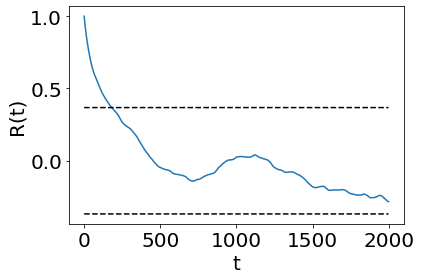

In [96]:
for key in data_C_burn_in_all.keys():
    plot_corr(torch.stack(data_C_burn_in_all[key][-5000:]), lag = 2000)

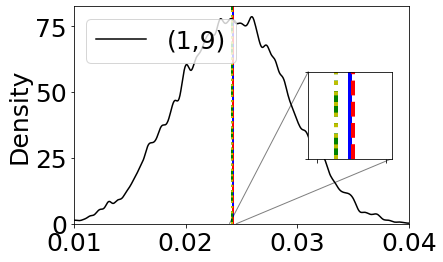

In [138]:
# Simulatio data usig algorithm 1 from Ma et al.
C_ma = np.array([[0.        , 0.00302687, 0.00604929, 0.00905718, 0.01206826,
        0.01508169, 0.01809459, 0.02111846, 0.02413527, 0.02713585],
       [0.00302687, 0.        , 0.00301979, 0.0060396 , 0.00904599,
        0.01205467, 0.01505718, 0.0180816 , 0.02110609, 0.02411641],
       [0.00604929, 0.00301979, 0.        , 0.00302517, 0.00603942,
        0.00905489, 0.01206815, 0.01508328, 0.01809468, 0.02111088],
       [0.00905718, 0.0060396 , 0.00302517, 0.        , 0.00302899,
        0.00604367, 0.00905545, 0.01206413, 0.01509075, 0.01810052],
       [0.01206826, 0.00904599, 0.00603942, 0.00302899, 0.        ,
        0.00302685, 0.00602421, 0.00904756, 0.01206728, 0.01506749],
       [0.01508169, 0.01205467, 0.00905489, 0.00604367, 0.00302685,
        0.        , 0.00300792, 0.00602699, 0.00904998, 0.01206237],
       [0.01809459, 0.01505718, 0.01206815, 0.00905545, 0.00602421,
        0.00300792, 0.        , 0.00300685, 0.00601826, 0.00904137],
       [0.02111846, 0.0180816 , 0.01508328, 0.01206413, 0.00904756,
        0.00602699, 0.00300685, 0.        , 0.00301802, 0.00601525],
       [0.02413527, 0.02110609, 0.01809468, 0.01509075, 0.01206728,
        0.00904998, 0.00601826, 0.00301802, 0.        , 0.00301405],
       [0.02713585, 0.02411641, 0.02111088, 0.01810052, 0.01506749,
        0.01206237, 0.00904137, 0.00601525, 0.00301405, 0.        ]])

C_ma2 = np.array([[0.        , 0.00302687, 0.00604929, 0.00905718, 0.01206826,
        0.01508169, 0.01809459, 0.02111846, 0.02413527, 0.02713585],
       [0.00302687, 0.        , 0.00301979, 0.0060396 , 0.00904599,
        0.01205467, 0.01505718, 0.0180816 , 0.02110609, 0.02411641],
       [0.00604929, 0.00301979, 0.        , 0.00302517, 0.00603942,
        0.00905489, 0.01206815, 0.01508328, 0.01809468, 0.02111088],
       [0.00905718, 0.0060396 , 0.00302517, 0.        , 0.00302899,
        0.00604367, 0.00905545, 0.01206413, 0.01509075, 0.01810052],
       [0.01206826, 0.00904599, 0.00603942, 0.00302899, 0.        ,
        0.00302685, 0.00602421, 0.00904756, 0.01206728, 0.01506749],
       [0.01508169, 0.01205467, 0.00905489, 0.00604367, 0.00302685,
        0.        , 0.00300792, 0.00602699, 0.00904998, 0.01206237],
       [0.01809459, 0.01505718, 0.01206815, 0.00905545, 0.00602421,
        0.00300792, 0.        , 0.00300685, 0.00601826, 0.00904137],
       [0.02111846, 0.0180816 , 0.01508328, 0.01206413, 0.00904756,
        0.00602699, 0.00300685, 0.        , 0.00301802, 0.00601525],
       [0.02413527, 0.02110609, 0.01809468, 0.01509075, 0.01206728,
        0.00904998, 0.00601826, 0.00301802, 0.        , 0.00301405],
       [0.02713585, 0.02411641, 0.02111088, 0.01810052, 0.01506749,
        0.01206237, 0.00904137, 0.00601525, 0.00301405, 0.        ]])

matplotlib.rcParams.update({'font.size': 25})
plot_pdf_all(data_C_all, C, C_ma, C_ma2)

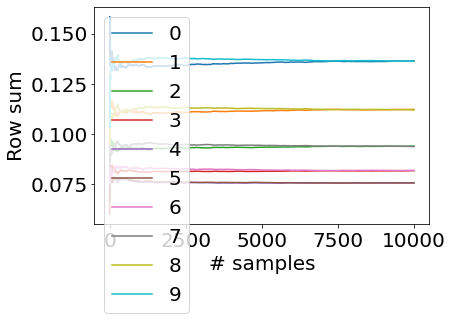

In [98]:
for key in data_C_burn_in_all.keys():
    plot_row_sum_running_average(data_C_all[key])


In [101]:

def relative_error(a, b):
    return np.linalg.norm(a-b) / np.linalg.norm(b)


def get_median(data):
    tmp = [data[j].numpy() for j in range(len(data)) ]
    med = np.median(tmp, axis=0)
    error_med = relative_error(torch.tensor(med), C)
    return error_med


N = len(data_C)
steps = 1
error = get_median(data_C[0:])
print(error)

0.0023289381402721195


In [ ]:
with open('data_symmetric.pkl', 'wb') as handle:
    pickle.dump(data_C_all, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('data_C_burn_in_response.pkl', 'wb') as handle:
    pickle.dump(data_C_burn_in_all, handle, protocol=pickle.HIGHEST_PROTOCOL)